In [1]:
# in this file, we do: 
# 1. implement the Adaptive GA to optimize chiplet design layout
#   a. implement fitness function
#       i. how do we measure fitness? 
#           - max temperature (done)
#           - Temperature distribution uniformity (done)
#           - total interconnect length between chips (temp done, with all connected situation)
#               - the closest edges' mid point interline lengths
#           - how to calculate above?
#               - can we do it faster?
#   b. for each operation in GA: 
#       i. selection: 
#           - elite selection?
#       ii. crossover
#           - rate of crossover?
#           - increase?
#       iii. mutation
#           - rate of mutation?
#           - decay?
#           - opeartions: 
#               - add a random value to the horizontal or vertical coordinate
#               - rotate the chiplet 90 degree clockwise 
#               - swap the position of two chiplets
#               - move the position of a chiplet randomly
#   c. make the codes adaptive to various number of chiplets cases
#       i. the unit length / the edge length of a minimum grid on the board

# ii. temperature distribution visualization 

In [2]:
import ExponentialDecayModel as EDM
import InChipModel as ICM
import torch
import pandas
import utilities
import numpy as np
import math
import temperature_calculator as temp_cal
import interconnect_calculator as inter_cal
import random
import copy
from multiprocessing import Pool   
from concurrent.futures import ProcessPoolExecutor


d:\project\XDU_LX\C-TAD\stage2_1\InChipModel.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inchip_pred_model.load_state_dict(torch.load(inchip_model_weight_file_path)

In [3]:
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore", message=".*does not have valid feature names.*")


In [4]:
# fitness function: 

# get the max temperature

# get the temperature uniformity

# get the total interconnect length


In [5]:
# constraints


def is_overlapping(chip1, chip2, min_edge_dist:float=0.2): 
    """
    Check if two chiplets are overlapping.
    input: 
        chip1: the first chiplet
        chip2: the second chiplet
        min_edge_dist: the minimum edge distance between two chiplets
    output: 
        True: if two chiplets are overlapping
        False: if two chiplets are not overlapping
    """
    x1, y1 = chip1[0], chip1[1]
    w1, h1 = chip1[2], chip1[3]
    x2, y2 = chip2[0], chip2[1]
    w2, h2 = chip2[2], chip2[3]
    no_overlap = (
        x1 + w1 + min_edge_dist <= x2 or  # Chiplet1 is to the left of Chiplet2
        x2 + w2 + min_edge_dist <= x1 or  # Chiplet2 is to the left of Chiplet1
        y1 + h1 + min_edge_dist <= y2 or  # Chiplet1 is below Chiplet2
        y2 + h2 + min_edge_dist <= y1     # Chiplet2 is below Chiplet1
    )

    return not no_overlap

def check_overlap_within_layout(layout, chiplets):
    """
    Check if there are overlapping chiplets within the layout.
    input: 
        layout: the layout of the chiplets
        chiplets: the chiplets
    output: 
        True: if there are overlapping chiplets
        False: if there are no overlapping chiplets
    """
    n = len(layout)
    # overlapping_pairs = []
    for i in range(n):
        for j in range(i + 1, n):  # Avoid redundant comparisons and self-comparisons
            if is_overlapping(layout[i], layout[j]):
                # overlapping_pairs.append((i, j))
                return True
    
    # return overlapping_pairs 
    return False


In [6]:
# general helper function
def get_shape_of_board(layout, chiplets, margin_width=1.0): 
    """
    Get the shape of the board.
    input: 
        layout: the layout of the chiplets
        chiplets: the chiplets
        margin_width: the margin width of the board
    output: 
        the shape of the board: length and width of the board
    """
    x_max, x_min, y_max, y_min = float('-inf'), float('inf'),float('-inf'),float('inf')

    for chip in layout: 
        x_max = max(x_max, chip[0] + chiplets[chip[-1]]['len'])
        x_min = min(x_min, chip[0])
        y_max = max(y_max, chip[1] + chiplets[chip[-1]]['wid'])
        y_min = min(y_min, chip[1])

    board_len = abs(x_max - x_min) + 2 * margin_width
    board_wid = abs(y_max - y_min) + 2 * margin_width

    return [board_len, board_wid]

def get_chiplet_dict(chip_length, chip_width, Convection_Film_Coefficient, Internal_Heat_Generation_Magnitude): 
    """
    Get the dictionary of a chiplet.
    """
    chip = dict()
    chip['len'] = chip_length
    chip['wid'] = chip_width
    chip['CFC'] = Convection_Film_Coefficient
    chip['IHGM'] = Internal_Heat_Generation_Magnitude

    chip['A'], chip['k'] = EDM.get_decay_curve_coef(XD1=chip['len'],
                                                    YD1=chip['wid'],
                                                    XD2=chip['len'],
                                                    YD2=chip['wid'],
                                                    Convection_Film_Coefficient=chip['CFC'],
                                                    Internal_Heat_Generation_Magnitude=chip['IHGM'])

    return chip

def is_overlapping_grid(x_c, y_c, len_c, wid_c, index_c, layout, min_edge_dist): 
    """
    Check if a chiplet is overlapping with other chiplets in the layout.
    """
    curr_chip = [x_c, y_c, len_c, wid_c, len_c >= wid_c, index_c]
    for placed_chip in layout: 
        if is_overlapping(chip1=curr_chip, 
                          chip2=placed_chip, 
                          min_edge_dist=min_edge_dist): 
            return True
    return False

def generate_a_layout(grid_length, grid_width, chiplets: dict, min_edge_distance: float=2.0, margin_width: float=1.0): 
    """
    Generate a layout of chiplets.
    input: 
        grid_length: the length of the grid
        grid_width: the width of the grid
        chiplets: the chiplets
        min_edge_distance: the minimum edge distance between two chiplets
        margin_width: the margin width of the board
    output: 
        the layout of the chiplets
    """
    layout = []

    for index, chip in chiplets.items(): 
        placed = False
        
        while not placed: 
            if len(layout) >= 1:  
                while True: 
                    x = random.randint(0, grid_length - chip['len'])
                    y = random.randint(0, grid_width - chip['wid'])
                    if not is_overlapping_grid(x, y, chip['len'], chip['wid'], index, layout, min_edge_dist=min_edge_distance): 
                        layout.append([x, y, chip['len'], chip['wid'], chip['len'] >= chip['wid'], index])
                        placed = True
                        break
            else: 
                x = random.randint(0, grid_length - chip['len'])
                y = random.randint(0, grid_width - chip['wid'])
                layout.append([x, y, chip['len'], chip['wid'], chip['len'] >= chip['wid'], index])
                placed = True

    # 裁剪芯片板
    # for chip in layout: 
    # x_max = max(x_max, chip[0] + chiplets[chip[-1]]['len'])
    x_min = min(chip[0] for chip in layout)
    # y_max = max(y_max, chip[1] + chiplets[chip[-1]]['wid'])
    y_min = min(chip[1] for chip in layout)

    x_move, y_move = x_min - margin_width, y_min - margin_width

    # 更新芯片定位点位置
    for i in range(len(layout)): 
        layout[i][0] -= x_move
        layout[i][1] -= y_move
    return layout

def get_dynamic_coefficient(current_epoch, total_epochs):
    if current_epoch <= total_epochs * 0.1:
        return 1.0  # First 10% of epochs
    elif current_epoch <= total_epochs * 0.3:
        return 0.8  # Next 20% of epochs
    elif current_epoch <= total_epochs * 0.5:
        return 0.6  # Mid-point epochs
    elif current_epoch <= total_epochs * 0.7:
        return 0.4  # Late mid-point epochs
    else:
        return 0.2



In [7]:
# GA part

def fitness(layout, connectivity, chiplets): 
    """
    Calculate the fitness of a layout.
    input: 
        layout: the layout of the chiplets
        connectivity: the connectivity pairs
        chiplets: the chiplet dictionary
    output: 
        the fitness of the layout
    """

    inter_connect_length = inter_cal.get_total_interconnect_length(layout=layout, connectivity_pairs=connectivity)
    max_temp, temp_uniformity = temp_cal.get_max_temp_and_temp_uniformity(layout, chiplets)
    
    # add overlap penalty to the fitness
    overlap_penalty = 10000 if check_overlap_within_layout(layout, chiplets) else 0

    # add shape score to the fitness (we prefer chiplets stay closer)
    board_len, board_wid = utilities.get_chip_board_size(layout, margin_width=1.0)
    shape_ratio = board_len / board_wid
    shape_score = 5 * (1/shape_ratio + shape_ratio)
    
    return 5.0*inter_connect_length + shape_score + overlap_penalty # + temp_uniformity + max_temp

def select(population, fitnesses):
    """
    Select two individuals from the population based on their fitness.
    """
    return random.choices(population, weights=fitnesses, k=2)

def crossover(parent1, parent2, connectivity,chiplets):
    """
    Perform crossover between two parents.
    input: 
        parent1: the first parent
        parent2: the second parent
        chiplets: the chiplet dictionary
    output: 
        the two children
    """
    max_attempts = len(parent1)
    
    result = [[parent1, fitness(parent1, connectivity, chiplets)], [parent2, fitness(parent2, connectivity, chiplets)]]
    result.sort(key=lambda x: x[1])
    
    for p in range(1, max_attempts-1): 
        # point = random.randint(1, len(parent1) - 1)
        child1 = parent1[:p] + parent2[p:]
        child2 = parent2[:p] + parent1[p:]

        
        # child2 = parent2[:p] + parent1[p:]

        if not check_overlap_within_layout(child1, chiplets): 
            temp = [child1, fitness(child1, connectivity, chiplets)]
            if temp[1] < result[0][1]: 
                result.insert(0, temp)
                result.pop()
            elif temp[1] < result[1][1]: 
                result.insert(1, temp)
                result.pop()
            # return child1, parent1

        if not check_overlap_within_layout(child2, chiplets): 
            temp = [child2, fitness(child2, connectivity, chiplets)]
            if temp[1] < result[0][1]: 
                result.insert(0, temp)
                result.pop()
            elif temp[1] < result[1][1]: 
                result.insert(1, temp)
                result.pop()
            # return result[0][0], result[1][0]

    return result[0][0], result[1][0]

def mutate(individual, chiplets, curr_epoch, max_epoch, max_attempt=10, margin_width=1.0):
    """
    Perform mutation on an individual.
    input: 
        individual: the individual (layout)
        chiplets: the chiplet dictionary
        curr_epoch: the current epoch
        max_epoch: the maximum epoch
        max_attempt: the maximum attempt for a mutation
        margin_width: the margin width of the board
    output: 
        the mutated individual
    """
    
    for i, chiplet in enumerate(individual):  # make every chiplet has a chance to mutate
        
        is_mutated = random.random() < 0.3

        if is_mutated:
            original_chip = copy.deepcopy(chiplet)
            attempts = 0
            while attempts < max_attempt: 
                
                mutate_direction = random.random()
                if mutate_direction < 0.8: # 芯片平移突变 (将芯片向水平或垂直方向移动)
                    # index = random.randint(0, len(individual) - 1)
                    
                    # Decide move direction (0: horizontal, 1: vertical)
                    move_direction = random.randint(0, 1)
                    
                    factor = get_dynamic_coefficient(current_epoch=curr_epoch, total_epochs=max_epoch)
                    upper, lower = factor * 10, factor * (-10)
                    if move_direction == 0:  # Horizontal move
                        x_offset = random.uniform(upper, lower)
                        individual[i][0] += x_offset
                    else:  # Vertical move
                        y_offset = random.uniform(upper, lower)
                        individual[i][1] += y_offset

                    # Check for overlaps
                    if check_overlap_within_layout(individual, chiplets):
                        # 回溯
                        individual[i] = original_chip
                        attempts += 1
                        continue

                    # Adjust board coordinates to ensure positive positioning
                    x_min = min(chip[0] for chip in individual)
                    y_min = min(chip[1] for chip in individual)
                    
                    # 更新芯片定位点位置
                    for chip in individual: 
                        chip[0] -= (x_min - margin_width)
                        chip[1] -= (y_min - margin_width)
                    break
                    
                elif mutate_direction < 0.95: # 芯片换位突变 (交换任意两个芯片的定位点位置) 

                    swap_i = random.sample(range(len(individual)), 1)[0]

                    individual[i][0], individual[swap_i][0] = individual[swap_i][0], individual[i][0]
                    individual[swap_i][1], individual[i][1] = individual[i][1], individual[swap_i][1]
                    

                    if check_overlap_within_layout(individual, chiplets): 
                        # 回溯
                        individual[i][0], individual[swap_i][0] = individual[swap_i][0], individual[i][0]
                        individual[i][1], individual[swap_i][1] = individual[swap_i][1], individual[i][1]
                        attempts += 1
                        continue
                    # Adjust board coordinates to ensure positive positioning
                    x_min = min(chip[0] for chip in individual)
                    y_min = min(chip[1] for chip in individual)
                    
                    # 更新芯片定位点位置
                    for chip in individual: 
                        chip[0] -= (x_min - margin_width)
                        chip[1] -= (y_min - margin_width)
                    break
                    
                else: # 芯片旋转突变 (定位点不会改变，但是长宽位置会交换)
                    
                    # Swap length and width
                    individual[i][2], individual[i][3] = individual[i][3], individual[i][2]
                    
                    # Check for overlaps
                    if check_overlap_within_layout(individual, chiplets):
                        # 回溯
                        individual[i][2], individual[i][3] = individual[i][3], individual[i][2]
                        attempts += 1
                        continue

                    # 更新芯片定位点位置
                    x_min = min(chip[0] for chip in individual)
                    y_min = min(chip[1] for chip in individual)
                    for chip in individual: 
                        chip[0] -= (x_min - margin_width)
                        chip[1] -= (y_min - margin_width)
                        
                    chiplets[individual[i][5]]['len'], chiplets[individual[i][5]]['wid'] = \
                        chiplets[individual[i][5]]['wid'], chiplets[individual[i][5]]['len']
                
    return individual

def elitist_selection(population, fitnesses, num_elites):
    """
    Perform elitist selection.
    input:
        population: List of individuals (genes).
        fitnesses: List of fitness values corresponding to the population.
        num_elites: Number of top individuals to preserve.
    output:
        List of elite individuals.
    """
    # Sort population by fitness (ascending, since lower fitness is better)
    sorted_population = [x for _, x in sorted(zip(fitnesses, population))]
    # Preserve the top num_elites individuals
    elites = sorted_population[:num_elites]
    return elites

def genetic_algorithm(chiplets, connectivity, generations=200, population_size=50, num_elites=5, convergence_window=20, convergence_threshold=1): 
    """
    Implement the genetic algorithm.
    input: 
        chiplets: the chiplet dictionary
        connectivity: the connectivity pairs
        generations: the maximum generations
        population_size: the population size
        num_elites: the number of elites
        convergence_window: the convergence window
        convergence_threshold: the convergence threshold
    output: 
        the best layout
    """
    init_grid_len = (utilities.avg([chip['len'] for chip in chiplets.values()]) + 10) * len(chiplets.keys()) + 10
    init_grid_wid = (utilities.avg([chip['wid'] for chip in chiplets.values()]) + 10) * len(chiplets.keys()) + 10
    population = [generate_a_layout(grid_length=init_grid_len, 
                                    grid_width=init_grid_wid,
                                    chiplets=chiplets) for _ in range(population_size)]
    
    best_fitness_history = []
    
    for k in tqdm(range(0, generations), desc="generation"): 
        # print("interation starts")
        fitnesses = [fitness(layout, connectivity, chiplets) for layout in population]
        
        best_fitness = min(fitnesses)
        best_fitness_history.append(best_fitness)

        if len(best_fitness_history) >= convergence_window: 
            recent_window = best_fitness_history[-convergence_window:]
            fitness_variation = (max(recent_window) - min(recent_window)) / min(recent_window)

            if fitness_variation < convergence_threshold: 
                print("Converged")
                break

        elites = elitist_selection(population, fitnesses, num_elites)

        next_generation = elites[:]

        count = 0 # use a count to avoid infinite loop during crossover and mutation

        while len(next_generation) < population_size: 
            parent1, parent2 = select(population, fitnesses)
            # parent1, parent2 = parent1, parent2
            valid_child = False
            # print("In crossover")
            child1, child2 = crossover(parent1, parent2, connectivity, chiplets)
            # print("After crossover")
            if not check_overlap_within_layout(child1, chiplets): 
                # if random.random() < mutation_rate:
                child1 = mutate(child1, chiplets, k, generations)
                # child1.extend(get_shape_of_board(child1, chiplets))
                next_generation.append(child1)
                valid_child = True
        
            if not check_overlap_within_layout(child2, chiplets):
                # if random.random() < mutation_rate: 
                child2 = mutate(child2, chiplets, k, generations)
                # child2.extend(get_shape_of_board(child2, chiplets))
                next_generation.append(child2)  
                valid_child = True  

            if not valid_child: 
                count += 1
                if count > 100: # cannot find a valid child after 100 times, break
                    print("Cannot find a valid child after 100 times, early stop generating for this generation.")
                    print("Current population size: ", len(next_generation))
                    break
        # print("interation ends")
        population = next_generation[:population_size]
    
    # parallel processing here
    fitnesses = [fitness(layout, connectivity, chiplets) for layout in population]
    best_index = fitnesses.index(min(fitnesses))
    return population[best_index]
    # return population


In [8]:
# input = [
#     # [9, 9, 15, 140000000],
#     [6, 6, 15, 300000000],
#     [5, 5, 15, 80000000], 
#     [4, 4, 15, 120000000]
# ]
# chiplets = dict()
# chip_amount = len(input)
# chip_settings = []

# for i in range(chip_amount): 
#     chip_dict = get_chiplet_dict(chip_length=input[i][0],
#                                  chip_width=input[i][1],
#                                  Convection_Film_Coefficient=input[i][2],
#                                  Internal_Heat_Generation_Magnitude=input[i][3]) # pending fill the arguments
#     chiplets[i] = chip_dict
# connectivity = [(0, 1), (1, 2), (0,2), ]# (0, 3), (1, 3), (2,3)]
# popu = generate_a_layout(100, 100, chiplets)
# popu

In [9]:
# input the chiplets
input = [
    # [9, 9, 15, 140000000],
    [6, 6, 15, 300000000],
    [5, 5, 15, 80000000], 
    [4, 4, 15, 120000000]
]
chiplets = dict()
chip_amount = len(input)
chip_settings = []

for i in range(chip_amount): 
    chip_dict = get_chiplet_dict(chip_length=input[i][0],
                                 chip_width=input[i][1],
                                 Convection_Film_Coefficient=input[i][2],
                                 Internal_Heat_Generation_Magnitude=input[i][3]) # pending fill the arguments
    chiplets[i] = chip_dict
connectivity = [(0, 1), (1, 2), (0,2), ]# (0, 3), (1, 3), (2,3)]
design = genetic_algorithm(chiplets, connectivity, 
                           population_size=20*chip_amount,
                           num_elites=chip_amount*2, 
                           convergence_window=10*chip_amount, 
                           generations=1000,
                           convergence_threshold=0.1)



generation:   0%|          | 5/1000 [00:21<1:13:51,  4.45s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  7


generation:   2%|▏         | 23/1000 [01:32<1:12:08,  4.43s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  27


generation:   2%|▏         | 24/1000 [01:37<1:11:49,  4.42s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  14


generation:   3%|▎         | 30/1000 [02:06<1:31:33,  5.66s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  14


generation:   4%|▍         | 44/1000 [03:24<1:32:20,  5.80s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  26


generation:   8%|▊         | 76/1000 [06:09<1:27:20,  5.67s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  37


generation:  10%|▉         | 98/1000 [07:34<1:03:13,  4.21s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  49


generation:  10%|█         | 102/1000 [07:54<1:13:30,  4.91s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  15


generation:  11%|█         | 109/1000 [08:32<1:17:51,  5.24s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  41


generation:  13%|█▎        | 132/1000 [09:57<1:02:12,  4.30s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  43


generation:  15%|█▌        | 150/1000 [11:04<58:44,  4.15s/it]  

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  32


generation:  15%|█▌        | 151/1000 [11:09<1:00:50,  4.30s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  33


generation:  15%|█▌        | 152/1000 [11:13<1:01:40,  4.36s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  18


generation:  16%|█▌        | 158/1000 [11:35<53:29,  3.81s/it]  

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  8


generation:  16%|█▋        | 165/1000 [12:00<56:09,  4.04s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  41


generation:  17%|█▋        | 166/1000 [12:04<56:29,  4.06s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  16


generation:  17%|█▋        | 168/1000 [12:12<55:57,  4.04s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  35


generation:  18%|█▊        | 180/1000 [13:00<54:03,  3.96s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  17


generation:  18%|█▊        | 181/1000 [13:04<54:30,  3.99s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  16


generation:  19%|█▉        | 192/1000 [13:48<1:00:21,  4.48s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  8


generation:  20%|██        | 202/1000 [14:24<53:27,  4.02s/it]  

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  37


generation:  20%|██        | 203/1000 [14:29<53:32,  4.03s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  36


generation:  21%|██        | 212/1000 [14:58<42:11,  3.21s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  50


generation:  21%|██▏       | 213/1000 [15:01<43:38,  3.33s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  7


generation:  21%|██▏       | 214/1000 [15:04<41:21,  3.16s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  12


generation:  22%|██▏       | 223/1000 [15:35<49:37,  3.83s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  19


generation:  23%|██▎       | 232/1000 [16:06<48:19,  3.78s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  53


generation:  24%|██▍       | 238/1000 [16:29<47:00,  3.70s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  33


generation:  24%|██▍       | 240/1000 [16:36<46:50,  3.70s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  9


generation:  24%|██▍       | 242/1000 [16:45<52:12,  4.13s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  10


generation:  25%|██▍       | 247/1000 [17:09<1:03:28,  5.06s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  24


generation:  25%|██▌       | 252/1000 [17:37<1:07:29,  5.41s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  42


generation:  25%|██▌       | 253/1000 [17:40<1:01:32,  4.94s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  6


generation:  25%|██▌       | 254/1000 [17:44<55:48,  4.49s/it]  

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  6


generation:  26%|██▌       | 255/1000 [17:47<51:53,  4.18s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  7


generation:  26%|██▌       | 256/1000 [17:51<49:10,  3.97s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  7


generation:  26%|██▌       | 257/1000 [17:54<47:30,  3.84s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  10


generation:  26%|██▌       | 261/1000 [18:10<49:55,  4.05s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  6


generation:  26%|██▌       | 262/1000 [18:14<51:59,  4.23s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  41


generation:  27%|██▋       | 274/1000 [19:05<1:01:40,  5.10s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  58


generation:  28%|██▊       | 275/1000 [19:09<58:39,  4.85s/it]  

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  6


generation:  28%|██▊       | 276/1000 [19:13<55:01,  4.56s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  8


generation:  28%|██▊       | 277/1000 [19:17<52:35,  4.36s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  10


generation:  28%|██▊       | 278/1000 [19:21<50:45,  4.22s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  10


generation:  30%|██▉       | 297/1000 [20:38<54:50,  4.68s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  21


generation:  30%|██▉       | 298/1000 [20:42<51:07,  4.37s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  12


generation:  30%|███       | 303/1000 [21:01<49:52,  4.29s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  30


generation:  31%|███       | 311/1000 [21:29<45:16,  3.94s/it]

Cannot find a valid child after 100 times, early stop generating for this generation.
Current population size:  6


generation:  63%|██████▎   | 631/1000 [2:40:18<2:19:09, 22.63s/it]  

In [14]:
design

[[2.2048904490116463, 1.0, 6, 6, True, 0],
 [1.0, 6.791861753959838, 5, 5, True, 1],
 [37.221973329767025, 80.94077068398344, 4, 4, True, 2]]

In [11]:
fitness(design, connectivity, chiplets)

10845.759910574441

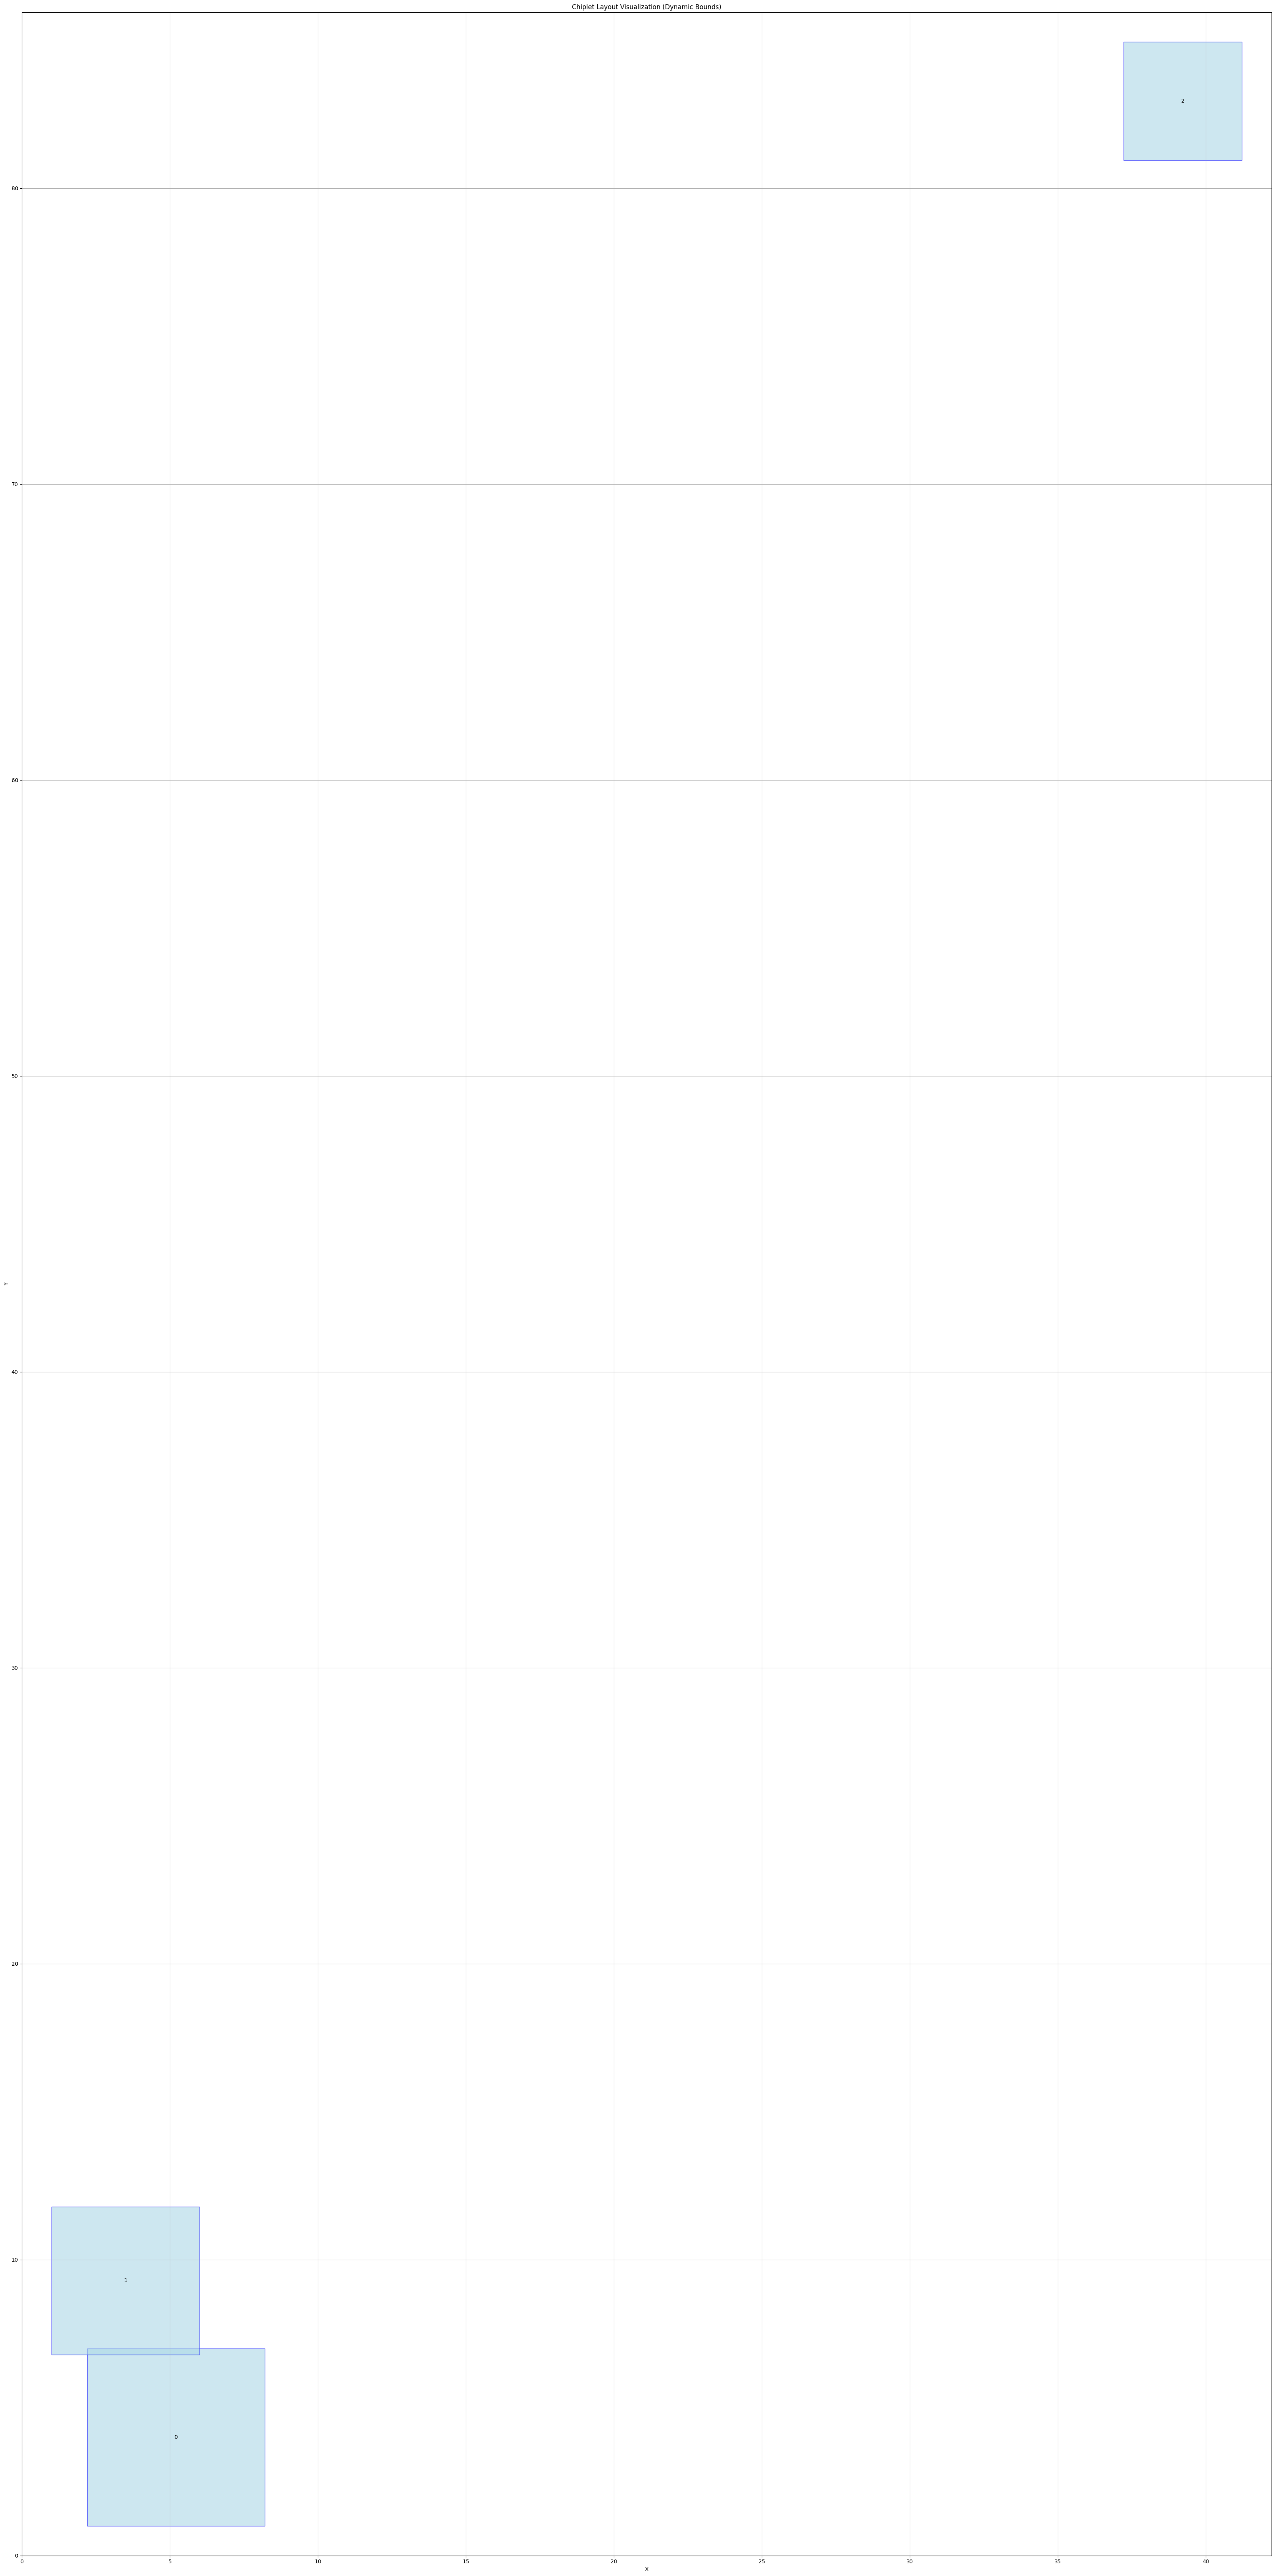

In [12]:
utilities.show_chip_design(layout=design)

In [12]:
check_overlap_within_layout(layout=[[1.0, 3.7248537263516597, 6, 6, True, 0],
 [3.4656367852649437, 7.21546515999106, 5, 5, True, 1],
 [4.374604448052565, 16.674617441401175, 4, 4, True, 2]], chiplets=chiplets
)

True

In [9]:
def harmonic_mean(x): 
    return 2/(1/x + x)

def plot_function(function, length=8): 
    import matplotlib.pyplot as plt

    positions = [i for i in range(1, length, 1)]

    results = list(map(function, positions))
    # fig, ax = plt.subplots(figsize=(length, 2))

    plt.figure(figsize=(length, 2))
    plt.plot(positions, results, "-", color='red')
    plt.grid(True)
    plt.show()
    

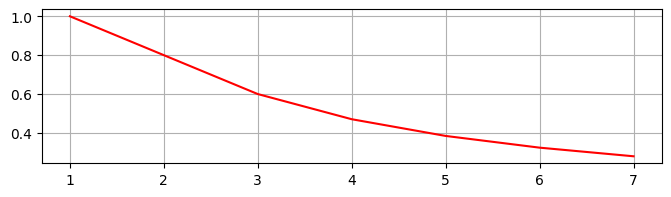

In [10]:
plot_function(harmonic_mean)